path = data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
...
extracted 3 dataframes
path = data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
...
path = data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出
data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出
...
extracted 3 dataframes
extracted 3 dataframes


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

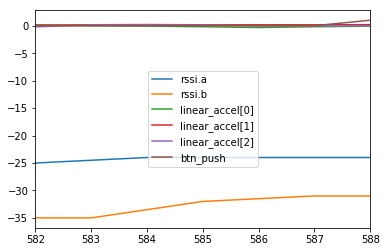

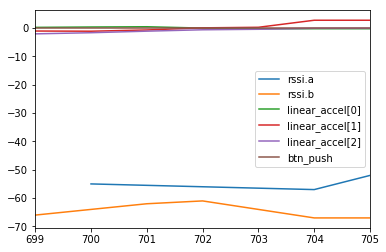

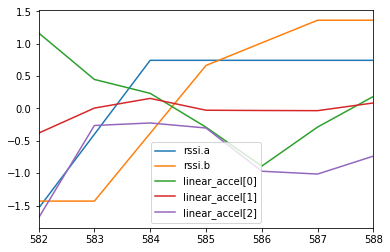

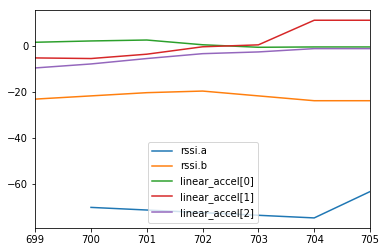

In [1]:
import sys
import notebookutil as nbu
sys.meta_path.append(nbu.NotebookFinder())
import datasets
import pandas as pd
import numpy as np

In [3]:
def eval00():
    # load dataset
    ds_nml = ds.dataset('data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅')
    ds_out = ds.dataset('data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出')

    # set column
    column = ['rssi.a','rssi.b',['linear_accel[0]','linear_accel[1]','linear_accel[2]']]

    # get around button pushed time
    dfl_nml = ds_nml.get_data(before=6, after=0, column=ds.list_flatten(column))
    dfl_out = ds_out.get_data(before=6, after=0, column=ds.list_flatten(column))

    # normalize
    mean_std = ds.get_mean_std(dfl_nml, column)
    dfl_nml_n = ds.normalize(dfl_nml, mean_std)
    dfl_out_n = ds.normalize(dfl_out, mean_std)
    #dfl_nml_n,ds.normalize(dfl_nml, dfl_out)

    # plot graph
    dfl_nml[1].plot()
    dfl_out[1].plot()
    dfl_nml_n[1].plot()
    dfl_out_n[1].plot()

    # calc k-NN distance
    from sklearn.neighbors import NearestNeighbors
    X_nml = [d.values.flatten() for d in dfl_nml_n]
    X_out = [d.values.flatten() for d in dfl_out_n]
    nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree')
    nbrs.fit(X_nml)

    distances, indices = nbrs.kneighbors(X_nml)
    print(distances)
    distances, indices = nbrs.kneighbors(X_out)
    print(distances)

    df_result = pd.DataFrame([[]])

In [9]:
def eval01():
    ds = datasets.load('data/raw/01_0[12]_01_*')
    column = ['rssi.a','rssi.b',['linear_accel[0]','linear_accel[1]','linear_accel[2]','btn_push']]
    data_n, data_o = datasets.get_normalized_data(ds,
                                                  title_n='01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅',
                                                  title_o ='01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出',
                                                  before=6, after=0, column=column)
    return data_n, data_o

eval01()

path = data/raw/01_0[12]_01_*
data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出
...
data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
...
extracted 3 dataframes
extracted 3 dataframes


([array([[-2.24882957, -2.24217501,  0.00802648, -0.7490215 ,  1.44447268],
         [-1.24403338, -0.7354334 ,  1.02520122, -0.62894129,  1.79696902],
         [-1.24403338,  0.7713082 , -0.53462343, -0.53184433,  1.3007043 ],
         [-1.24403338,  0.0179374 , -1.60522978,  0.33470862,  1.03984435],
         [-0.23923719, -0.7354334 , -2.5055322 ,  0.67976104,  1.81882993],
         [ 0.765559  ,  0.3946228 , -1.08216668,  1.41345932,  1.01605427],
         [ 0.765559  ,  1.52467901, -1.48594976,  1.14948776,  2.05003314]]),
  array([[-1.24403338, -1.48880421,  1.16665714, -0.38218257, -1.69154676],
         [-0.23923719, -1.48880421,  0.44751188,  0.00509458, -0.26397428],
         [ 0.765559  , -0.358748  ,  0.23274656,  0.15451044, -0.22493233],
         [ 0.765559  ,  0.7713082 , -0.29003271, -0.0280197 , -0.30244299],
         [ 0.765559  ,  1.14799361, -0.89150241, -0.03218764, -0.97027548],
         [ 0.765559  ,  1.52467901, -0.28830427, -0.03464665, -1.01404227],
         [